In [6]:
from Bio.PDB import *

from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.DSSP import DSSP
from Bio.PDB.DSSP import dssp_dict_from_pdb_file
from Bio import SeqIO
from Bio.SeqUtils import seq1
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import pickle
import os
from os import path
from os.path import isfile, join, dirname, isdir, exists

from IPython.display import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as linalg
from scipy import sparse
import scipy.signal

import sys

import math



def getUnweightedLaplacianEigsDense(W):
    D = sparse.dia_matrix((W.sum(1).flatten(), 0), W.shape).toarray()
    L = D - W
    try:
        _, v = linalg.eigh(L)
    except:
        return np.zeros_like(W)
    return v

def get_csm(X, Y):
    if len(X.shape) == 1:
        X = X[:, None]
    if len(Y.shape) == 1:
        Y = Y[:, None]
    C = np.sum(X**2, 1)[:, None] + np.sum(Y**2, 1)[None, :] - 2*X.dot(Y.T)
    C[C < 0] = 0
    return np.sqrt(C)


def csm_to_binary(D, kappa):
    N = D.shape[0]
    M = D.shape[1]
    if kappa == 0:
        return np.ones_like(D)
    elif kappa < 1:
        NNeighbs = int(np.round(kappa*M))
    else:
        NNeighbs = kappa
    J = np.argpartition(D, NNeighbs, 1)[:, 0:NNeighbs]
    I = np.tile(np.arange(N)[:, None], (1, NNeighbs))
    V = np.ones(I.size)
    [I, J] = [I.flatten(), J.flatten()]
    ret = sparse.coo_matrix((V, (I, J)), shape=(N, M), dtype=np.uint8)
    return ret.toarray()

def csm_to_binary_mutual(D, kappa):
    return csm_to_binary(D, kappa)*(csm_to_binary(D.T, kappa).T)

def sliding_window(dist, win):
    N = D.shape[0]
    dist_stack = np.zeros((N-win+1, N-win+1))
    for i in range(0, win):
        dist_stack += dist[i:i+N-win+1, i:i+N-win+1]
    for i in range(N-win+1):
        dist_stack[i, i] = 0
    return dist_stack

def make_dir(*argv):
    mydir = path.join(*argv)    
    if not path.exists(mydir):        
        if len(argv) > 1:
            make_dir(*argv[:-1])            
        os.mkdir(mydir)
    return mydir


def make_path(*argv):
    mypath = path.join(*argv)
    if not path.exists(dirname(mypath)):
        make_dir(*argv[:-1])
    return mypath

def get_fasta_record(file, seqid):
    with open(file) as handle:
        for record in SeqIO.parse(handle, "fasta"):
            if record.id == seqid:
                return record
        raise Exception('did not find sequence')
    
def avgper(motifs):    
    diff = [second - first for first, second in zip(motifs, motifs[1:])]
    return int(np.mean(diff))

In [10]:
with open('pickles/uniprot_d.pickle', 'rb') as handle:
    uniprot_d = pickle.load(handle)

In [8]:
if False:

    import subprocess

    for tairid, uniid in uniprot_d.items():
        subprocess.run(['gunzip', 'afdb/AF-%s-F1-model_v4.pdb.gz'%uniid])    

In [11]:
break
uniprot_d['AT5G51630.2'] = 'A0A1P8BAZ5'
uniprot_d['AT1G63750.1'] = 'F4I3Q8'
uniprot_d['AT4G19500.2'] = 'F4JT79'
uniprot_d['AT1G63740.1'] = 'F4I3Q6'
uniprot_d['AT4G16890.1'] = 'A0A1P8B8K4'
uniprot_d['AT4G14370.1'] = 'O23293'
uniprot_d['AT5G36930.1'] = 'F4K5U7'
uniprot_d['AT1G63750.2'] = 'F4I3Q8'
uniprot_d['AT4G19510.1'] = 'A0A1P8B4P2'
uniprot_d['AT5G45210.1'] = 'Q9FKE4'


In [15]:
break
irreconcilable = ['AT1G51480.1', 'AT3G25510.1', 'AT4G16890.1', 'AT4G14370.1']

for code in irreconcilable:
    if code in uniprot_d.keys():
        del uniprot_d[code]

In [64]:
break

counter =0
mismatches = []
for tairid, uniid in uniprot_d.items():
        
    parser = PDBParser()
    structure = parser.get_structure(uniid, 'afdb/AF-%s-F1-model_v4.pdb'%uniid)
    chain = list(structure.get_chains())[0]

    alpha_carbons = []
    pdbseq = ''

    for residue in chain.get_residues():
        # resseq = residue.get_full_id()[3][1]
        pdbseq += seq1(residue.get_resname())
        # alpha_carbons.append(np.array(list(residue["CA"].get_vector())))
    fastseq = str(get_fasta_record('protein/corr.Athaliana.protein.fasta', 'ATHALIANA_'+tairid.replace('.', '_')).seq)
    
    if fastseq!=pdbseq+'*':
        print(tairid, uniid, counter)
        mismatches.append((tairid, counter))
        print(fastseq)
        print(pdbseq)
    counter += 1

with open("protein/uniprot_col-0_nlrome.fasta", "w") as output_handle:
    for uniid in set(uniprot_d.values()):
        parser = PDBParser()
        if isfile('afdb/AF-%s-F1-model_v4.pdb'%uniid):
            structure = parser.get_structure(uniid, 'afdb/AF-%s-F1-model_v4.pdb'%uniid)
        elif isfile('afdb/AF-%s-F1-model_v4.pdb.gz'%uniid):
            subprocess.run(['gunzip', 'afdb/AF-%s-F1-model_v4.pdb.gz'%uniid])
        else:
            raise Exception(uniid)
            
        chain = list(structure.get_chains())[0]

        pdbseq = ''

        for residue in chain.get_residues():
            # resseq = residue.get_full_id()[3][1]
            pdbseq += seq1(residue.get_resname())
            # alpha_carbons.append(np.array(list(residue["CA"].get_vector())))
    
        record = SeqRecord(Seq(pdbseq))
        record.id = uniid
        record.description = ''
        SeqIO.write(record, output_handle, "fasta")


    

In [70]:
break

mismatches = []
prefix = []

with open("protein/mismatch_col-0_nlrome.fasta", "w") as output_handle:
    for counter, (tairid, uniid) in enumerate(uniprot_d.items()):
        parser = PDBParser()
        if isfile('afdb/AF-%s-F1-model_v4.pdb'%uniid):
            structure = parser.get_structure(uniid, 'afdb/AF-%s-F1-model_v4.pdb'%uniid)
        elif isfile('afdb/AF-%s-F1-model_v4.pdb.gz'%uniid):
            subprocess.run(['gunzip', 'afdb/AF-%s-F1-model_v4.pdb.gz'%uniid])
        else:
            raise Exception(uniid)
            
        chain = list(structure.get_chains())[0]

        pdbseq = ''

        for residue in chain.get_residues():
            # resseq = residue.get_full_id()[3][1]
            pdbseq += seq1(residue.get_resname())
            # alpha_carbons.append(np.array(list(residue["CA"].get_vector())))
        fastseq = str(get_fasta_record('protein/corr.Athaliana.protein.fasta', 'ATHALIANA_'+tairid.replace('.', '_')).seq)
        if fastseq!=pdbseq+'*':
            if fastseq.startswith(pdbseq):
                prefix.append((tairid, uniid))
            else:
                print(tairid, uniid, counter)
                print(pdbseq)
                print(fastseq)
                mismatches.append((tairid, uniid))

                record = SeqRecord(Seq(pdbseq))
                record.id = uniid
                record.description = ''
                SeqIO.write(record, output_handle, "fasta")

AT1G58400.1 Q8W3K3 5
MVEAIVSFGVEKLWDRLTQEYEQFQGVEDRIAELKSNLNLLKSFLKDAEAKKNTSQMVRHCVEEIKEIVYDTENMIETFILKEAARKRSGIIRRITKLTCIKVHRWEFASDIGGISKRISKVIQDMHSFGVQQMISDGSQSSHLLQEREREMRQTFSRGYESDFVGLEVNVKKLVGYLVEEDDIQIVSVTGMGGLGKTTLARQVFNHEDVKHQFDRLAWVCVSQEFTRKNVWQMILQNLTSRETKDEILQMEEAELHDELFQLLETSKSLIVFDDIWKEEDWGLINPIFPPKKGWKVLITSRTETIAMHGNRRYVNFKPECLTILESWILFQRIAMPRVDESEFKVDKEMEMMGKQMIKYCGGLPLAVKVLGGLLAAKYTFHDWKRLSENIGCHIVGRTDFSDGNNSSVYHVLSLSFEELPSYLKHCFLYLAHFPEDHNIKVEKLSYCWAAEGILEPRHYHGQTIRDVGESYIEELVRRNMVIAERDVTTLRFEACHLHDMMREVCLLKAKEENFVQIASILPPTANSQYPGTSRRFVSQNPTTLHVSRDINNPKLQSLLIVWENRRKSWKLLGSSFIRLELLRVLDLYKAKFEGRNLPSGIGKLIHLRYLNLDLARVSRLPSSLGNLRLLIYLDINVCTKSLFVPNCLMGMHELRYLRLPFNTSKEIKLGLCNLVNLETLENFSTENSSLEDLRGMVSLRTLTIGLFKHISKETLFASILGMRHLENLSIRTPDGSSKFKRIMEDGIVLDAIHLKQLNLRLYMPKLPDEQHFPSHLTSISLDGCCLVEDPLPILEKLLELKEVRLDFRAFCGKRMVSSDGGFPQLHRLYIWGLAEWEEWIVEEGSMPRLHTLTIWNCQKLKQLPDGLRFIYSIKDLDMDKKWKEILSEGGEEYYKVQHIPSVKFEKDYK
MVEAIVSFGVEKLWDRLTQEYEQFQGVEDRIAELKSNLNLLKSFLKDAEAKKNTSQMVRHCVEEIKEI

In [14]:
break

mismatch = []
matches = []
prefix = []

with open("protein/match_col-0_nlrome.fasta", "w") as output_handle:
    for counter, (tairid, uniid) in enumerate(uniprot_d.items()):
        parser = PDBParser()
        if isfile('afdb/AF-%s-F1-model_v4.pdb'%uniid):
            structure = parser.get_structure(uniid, 'afdb/AF-%s-F1-model_v4.pdb'%uniid)
        elif isfile('afdb/AF-%s-F1-model_v4.pdb.gz'%uniid):
            subprocess.run(['gunzip', 'afdb/AF-%s-F1-model_v4.pdb.gz'%uniid])
        else:
            raise Exception(uniid)
            
        chain = list(structure.get_chains())[0]

        pdbseq = ''

        for residue in chain.get_residues():
            # resseq = residue.get_full_id()[3][1]
            pdbseq += seq1(residue.get_resname())
            # alpha_carbons.append(np.array(list(residue["CA"].get_vector())))
        fastseq = str(get_fasta_record('protein/corr.Athaliana.protein.fasta', 'ATHALIANA_'+tairid.replace('.', '_')).seq)
        if fastseq.startswith(pdbseq):
            if fastseq != pdbseq+'*':
                prefix.append(tairid, uniid)
            else:
                matches.append((tairid, uniid))
            record = SeqRecord(Seq(pdbseq))
            record.id = uniid
            record.description = ''
            SeqIO.write(record, output_handle, "fasta")            
        else:
            mismatch.append((tairid, uniid))

In [18]:
from collections import Counter

idcount = Counter(uniprot_d.values())
idcount
for tairid, uniid in matches:
    if idcount[uniid]>1:
        print(uniid, idcount[uniid])

Q9FL92 2
O04093 2
Q38834 2
F4JYI4 2
F4I552 2
F4J361 2
O04093 2
Q8W4J9 2
O64973 2
Q38834 2
F4I3Q8 2
Q940K0 2
Q9SZA7 2
F4I9F1 2
F4J361 2
Q9FG90 2
Q9SZA7 2
Q9LSX5 2
O64973 2
Q8W3K0 2
P0DKH5 2
Q8W4J9 2
Q9M285 2
F4I3S8 2
Q9FG90 2
F4I847 2
F4IEZ7 2
F4IBL4 2
Q9M285 2
F4I3Q8 2
F4J359 3
F4JNB7 2
Q0WPW2 2
Q9LSX5 2
Q8W3K0 2
Q9SZ67 3
F4IBE4 2
P0DI18 2
P0DI17 2
P0DI18 2
P0DI17 2


In [19]:
df = pd.read_csv('LRRPredictor/col-0-nlrome.txt', delimiter = '\t')

In [20]:
df

,annotation,start,score1,score2,score3,score4,score5,score6,score7,score8,...,m3,m4,m5,m6,b2,s1,s2,s3,s4,s5
0,Athaliana_AT1G10920_1,411,0.7727,0.6918,0.9758,0.5487,0.9087,0.4548,0.9973,0.5931,...,R,L,S,V,NaN,H,G,G,N,A
1,Athaliana_AT1G10920_1,433,0.6889,0.7828,0.9967,0.7282,0.8227,0.2791,0.9912,0.3711,...,S,L,L,Y,NaN,F,A,F,E,D
2,Athaliana_AT1G10920_1,461,0.9625,0.9656,1.0000,0.8604,0.9172,0.9015,1.0000,0.8416,...,V,L,D,L,NaN,S,R,V,K,F
3,Athaliana_AT1G10920_1,486,0.9223,0.9748,1.0000,0.9578,0.9065,0.9095,1.0000,0.8502,...,F,L,S,L,NaN,H,R,A,W,I
4,Athaliana_AT1G10920_1,509,0.9572,0.9759,1.0000,0.8697,0.9477,0.9049,1.0000,0.8438,...,Y,L,N,L,NaN,G,F,N,G,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,Athaliana_AT5G66910_1,704,0.9505,0.9630,1.0000,0.8442,0.9558,0.9031,0.9999,0.8706,...,V,L,R,M,NaN,C,S,C,M,N
2906,Athaliana_AT5G66910_1,728,0.9629,0.9757,1.0000,0.8856,0.9586,0.9037,1.0000,0.8078,...,S,L,D,I,NaN,S,H,C,L,G
2907,Athaliana_AT5G66910_1,752,0.9119,0.9499,1.0000,0.8627,0.9015,0.9015,0.9997,0.8108,...,N,I,S,M,NaN,R,K,C,S,G
2908,Athaliana_AT5G66910_1,772,0.9314,0.9400,1.0000,0.7841,0.9590,0.8912,0.9986,0.7736,...,N,L,E,V,NaN,K,C,D,E,V


In [30]:
break

motifs_d = {}
for tairid, uniid in matches:
    motifs = []
    foundProtein = False
    for ii in range(len(df)):
        if '.'.join(df['annotation'][ii].split('_')[1:]) == tairid:
            foundProtein = True
        elif foundProtein:            
            break
        if foundProtein:
            motifs.append(int(df['start'][ii]))
    motifs_d[(tairid, uniid)] = motifs

matches_d = {k:v for k,v in matches}
with open('pickles/nlrome_motifs_d.pickle', 'wb') as handle:
    pickle.dump(motifs_d, handle)

with open('pickles/nlrome_matches_d.pickle', 'wb') as handle:
    pickle.dump(matches_d, handle)        

SyntaxError: 'break' outside loop (667219891.py, line 1)

In [ ]:
with open('pickles/nlrome_motifs_d.pickle', 'rb') as handle:
    motifs_d = pickle.load(handle)

In [62]:
import Bio.PDB as bpdb

for (tairid, uniid), motifs in motifs_d.items():
    start_res, end_res=motifs[0],motifs[-1]

    parser = PDBParser()
    structure = parser.get_structure(uniid, 'afdb/%s.pdb'%uniid)

    chain = list(structure.get_chains())[0]

    class ResSelect(bpdb.Select):
        def accept_residue(self, res):
            if res.id[1] >= start_res and res.id[1] <= end_res:
                return True
            else:
                return False
            
    io = bpdb.PDBIO()        

    io.set_structure(chain)
    io.save(make_path('pdb', 'nlrome_LRR','%s.pdb'%uniid), ResSelect())

In [32]:
for (tairid, uniid), motifs in motifs_d.items():
    code = uniid

    parser = PDBParser()
    structure = parser.get_structure(uniid, 'afdb/AF-%s-F1-model_v4.pdb'%uniid)

    chain = list(structure.get_chains())[0]

    alpha_carbons = []
    for residue in chain.get_residues():
        alpha_carbons.append(np.array(list(residue["CA"].get_vector())))

    X = np.array(alpha_carbons[motifs[0]:motifs[-1]])
    np.save(make_path('npy', 'nlrome_X', '%s.npy'%tairid), X)
            
    #print out the number of residues in the chain, and print the locations of the LRR motif residues

    period = avgper(motifs)

    D = get_csm(X, X)
    # Clean up the matrix a bit by doing a sliding window of length roughly the period
    D = sliding_window(D, period)
    # Clean up the matrix even more by binarizing it with nearest neighbors
    B = csm_to_binary_mutual(D, 20)
    #B = B[0:400, 0:400]
    v = getUnweightedLaplacianEigsDense(1-B)
    with open(make_path('npy', 'nlrome_eigenmatrix', '%s.npy'%tairid), 'wb') as f:
        np.save(f, v[:, 0:29])

    plt.figure(figsize=(18, 6))
    plt.subplot(131)
    plt.imshow(D, cmap='magma_r')
    plt.title("Self-Similarity Matrix")
    plt.subplot(132)
    plt.imshow(B)
    plt.title("Binarized Self-Similarity Matrix")
    plt.subplot(133)
    plt.imshow(v[:, 0:29], aspect='auto', cmap='magma_r', interpolation='none')
    plt.title("Eigenvectors of Unweighted Graph Laplacian")
    plt.savefig(make_path('plots', 'nlrome_eigenmatrix', '%s.png'%tairid))
    # plt.show()
    plt.close()


In [37]:
df = pd.DataFrame([(uniid, tairid) for tairid, uniid in motifs_d.keys()])


In [38]:
df

,0,1
0,Q9FL92,AT5G45050.1
1,O04093,AT1G10920.1
2,Q9FF28,AT5G38350.1
3,F4IC69,AT1G12290.2
4,Q9SX38,AT1G50180.1
...,...,...
135,F4I594,AT1G64070.1
136,P0DI18,AT1G59218.1
137,P0DI17,AT1G58848.1
138,P0DI18,AT1G59218.2


{'B3H776',
 'F4HR53',
 'F4HR54',
 'F4I270',
 'F4I3Q6',
 'F4I3Q8',
 'F4I3S8',
 'F4I552',
 'F4I594',
 'F4I847',
 'F4I901',
 'F4I9F1',
 'F4IBE4',
 'F4IBL4',
 'F4IC69',
 'F4IEZ7',
 'F4IMF2',
 'F4J339',
 'F4J359',
 'F4J361',
 'F4JNA9',
 'F4JNB2',
 'F4JNB7',
 'F4JT78',
 'F4JT82',
 'F4JWL7',
 'F4JWL8',
 'F4JWM0',
 'F4JYI4',
 'F4K5U7',
 'F4KD45',
 'F4KD49',
 'F4KFY1',
 'F4KFY5',
 'F4KHH8',
 'F4KHI3',
 'F4KIF3',
 'O04093',
 'O22727',
 'O48573',
 'O64790',
 'O64973',
 'O65506',
 'O65507',
 'O81825',
 'O82484',
 'O82500',
 'P0CB16',
 'P0DI17',
 'P0DI18',
 'P0DKH5',
 'P60838',
 'P60839',
 'Q0WPW2',
 'Q38834',
 'Q39214',
 'Q42484',
 'Q8L3R3',
 'Q8RXS5',
 'Q8W3K0',
 'Q8W474',
 'Q8W4J9',
 'Q940K0',
 'Q9C646',
 'Q9C7X0',
 'Q9C8T9',
 'Q9CAD8',
 'Q9CAE0',
 'Q9CAK0',
 'Q9CAK1',
 'Q9FF28',
 'Q9FFS5',
 'Q9FFS6',
 'Q9FG90',
 'Q9FG91',
 'Q9FGT2',
 'Q9FH20',
 'Q9FHF0',
 'Q9FHF4',
 'Q9FHF6',
 'Q9FHG0',
 'Q9FI14',
 'Q9FJB5',
 'Q9FJG4',
 'Q9FJK8',
 'Q9FKB9',
 'Q9FKE2',
 'Q9FKE4',
 'Q9FKM9',
 'Q9FKN7',
 'Q9FKR7',

In [45]:
for uniid in set(df[0]):
    os.rename('afdb/AF-%s-F1-model_v4.pdb'%uniid, 'afdb/%s.pdb'%uniid)

In [53]:
len(os.listdir('afdb'))

157

In [40]:
df.to_excel('nlrome_eigselection.xlsx')

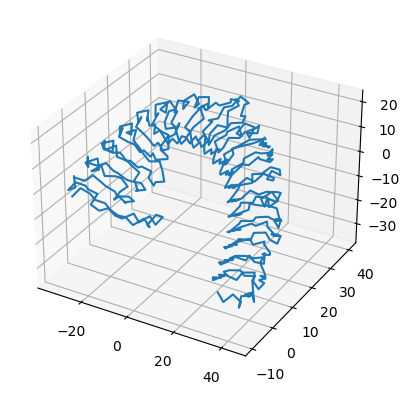

In [123]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[:, 0], X[:, 1], zs = X[:, 2])

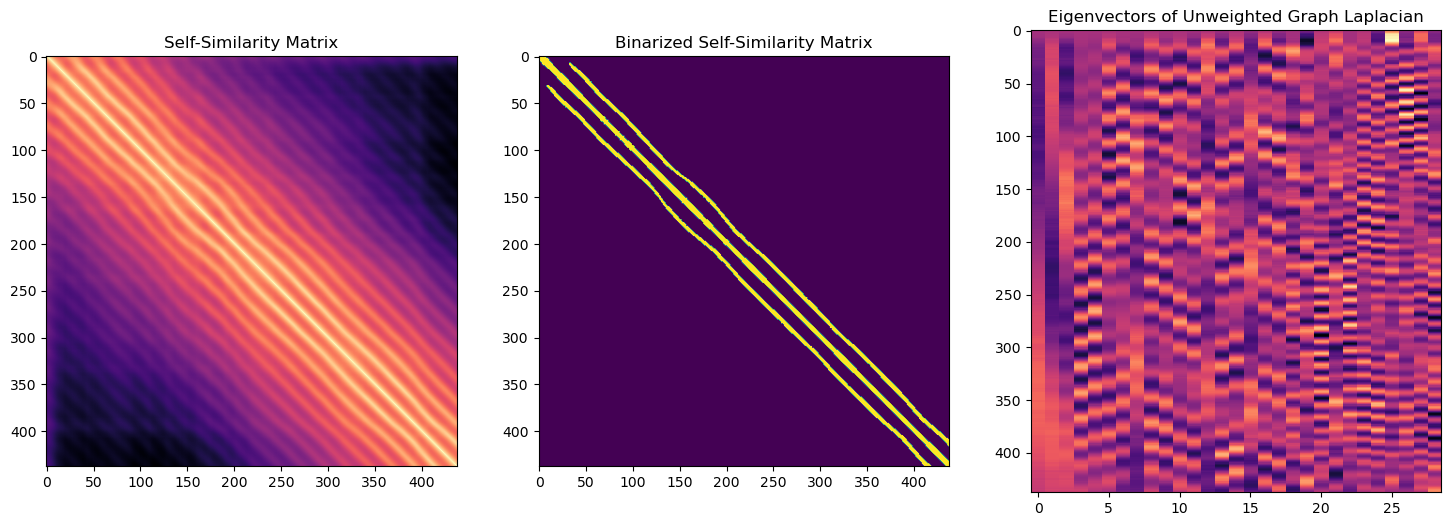

In [135]:
        
#print out the number of residues in the chain, and print the locations of the LRR motif residues

period = avgper(motifs)

D = get_csm(X, X)
# Clean up the matrix a bit by doing a sliding window of length roughly the period
D = sliding_window(D, period)
# Clean up the matrix even more by binarizing it with nearest neighbors
B = csm_to_binary_mutual(D, 20)
#B = B[0:400, 0:400]
v = getUnweightedLaplacianEigsDense(1-B)
with open(make_path('npy', 'nlrome', '%s.npy'%code), 'wb') as f:
    np.save(f, v[:, 0:29])

plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(D, cmap='magma_r')
plt.title("Self-Similarity Matrix")
plt.subplot(132)
plt.imshow(B)
plt.title("Binarized Self-Similarity Matrix")
plt.subplot(133)
plt.imshow(v[:, 0:29], aspect='auto', cmap='magma_r', interpolation='none')
plt.title("Eigenvectors of Unweighted Graph Laplacian")
plt.savefig(make_path('plots', 'nlrome', '%s.png'%code))
plt.show()
plt.close()

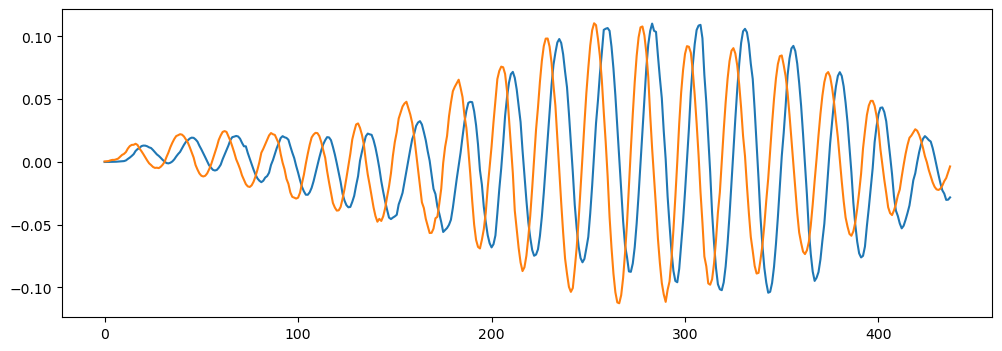

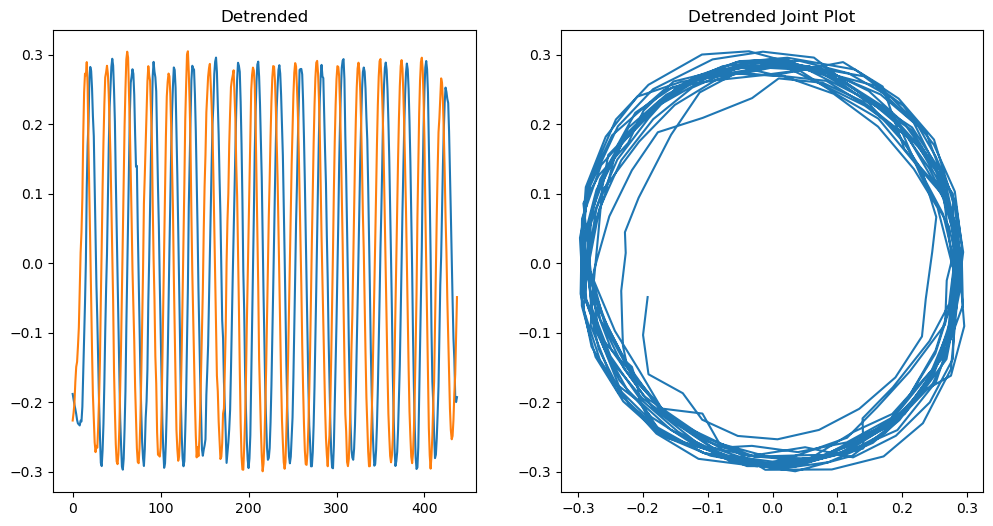

[555, 586, 611, 634, 659, 682, 704, 730, 756, 778, 802, 827, 851, 874, 898, 923, 947, 968, 992] [1016]


/var/folders/m0/rpw4gcbn5lxd8_3kt7g699rc0000gn/T/ipykernel_41843/2431845428.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(motifloc, theta[motifloc], 'bo', color='red')


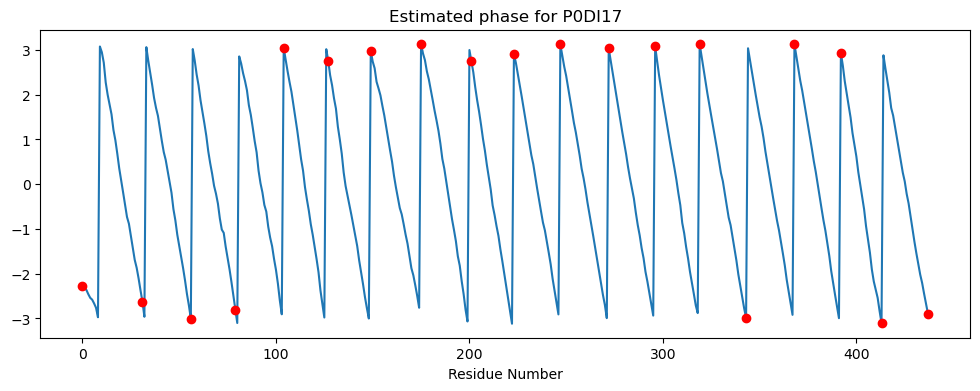

<function matplotlib.pyplot.close(fig=None)>

In [137]:

eig1,eig2 = 3,4

motifStart = 0
v = np.load('npy/validation_eigenmatrix/%s.npy'%code)

plt.figure(figsize=(12, 4))
s = v[:,eig1]
c = v[:, eig2]
plt.plot(s)
plt.plot(c)
plt.show()
from daps import *
# Detrend with daps
sf = detrend_timeseries(s, period)
cf = detrend_timeseries(c, period)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(sf)
plt.plot(cf)
plt.title("Detrended")
plt.subplot(122)
plt.title("Detrended Joint Plot")
plt.plot(sf, cf)
plt.show()

# Extract the final phase and plot

theta = np.arctan2(cf, sf)
plt.figure(figsize=(12, 4))
plt.plot(theta)

phases = []
ommitted =[]
plotted_motifs = []
for res in motifs:
    motifloc = res-motifStart-motifs[0]
    if motifloc<len(theta):
        plt.plot(motifloc, theta[motifloc], 'bo', color='red')
        phases.append(theta[motifloc])
        plotted_motifs.append(res)
    else:
        ommitted.append(res)
        phases.append(-4)

phases = np.array(phases)


plt.title("Estimated phase for %s" %code)
plt.xlabel("Residue Number")
plt.savefig(make_path('plots','validation/%s.png'%code))

np.save(make_path('npy','validation_phase', '%s.npy'%code), phases)
np.save(make_path('npy','validation_theta', '%s.npy'%code), theta)
np.save(make_path('npy','validation_plotted_motifs', '%s.npy'%code), np.array(plotted_motifs))
print(plotted_motifs, ommitted)

plt.show()
plt.close

25
[13, 34, 58, 82, 106, 131, 155, 179, 211]


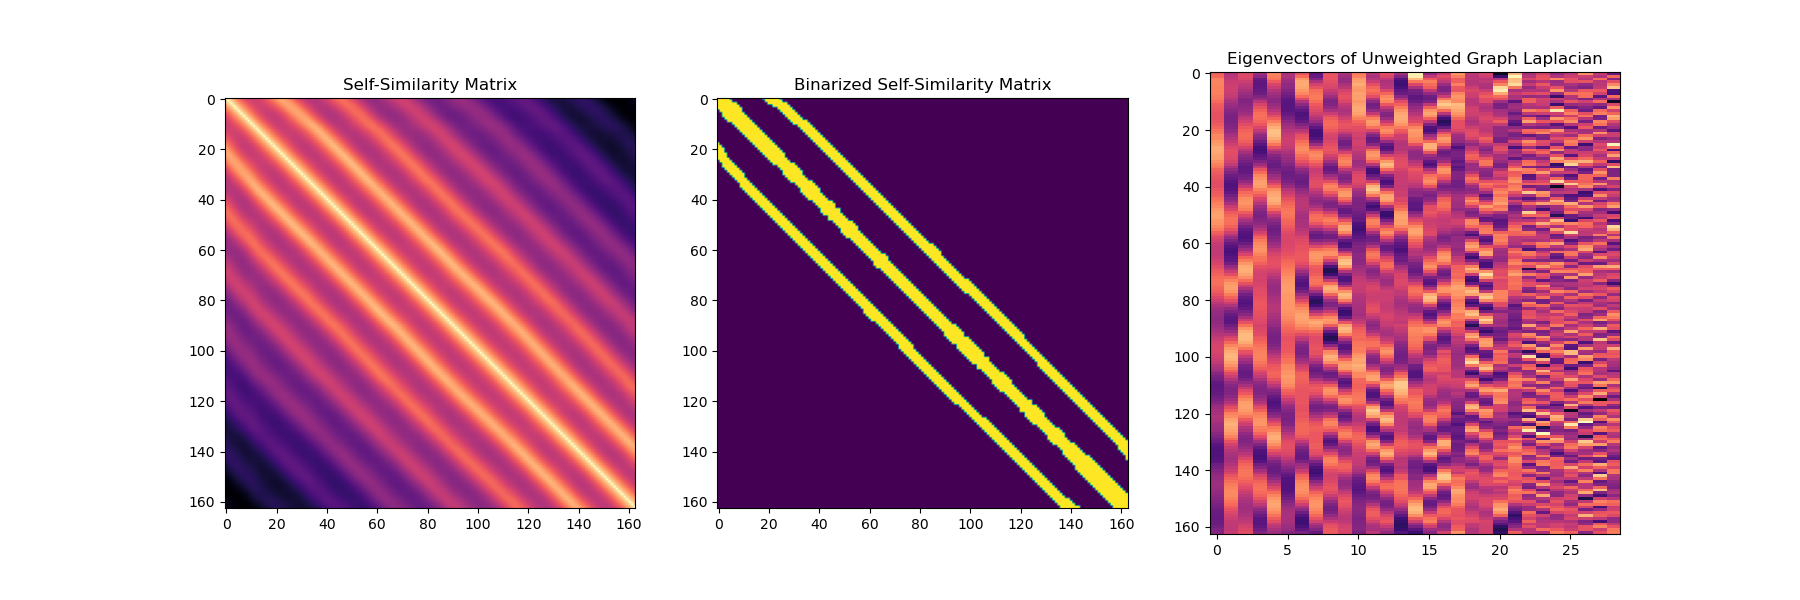

In [390]:
# code = '6GYUA'
period = avgper_d[code]
print(period)
print(motif_indices)
Image(filename='plots/validation_eigenmatrix/%s.png'%code)

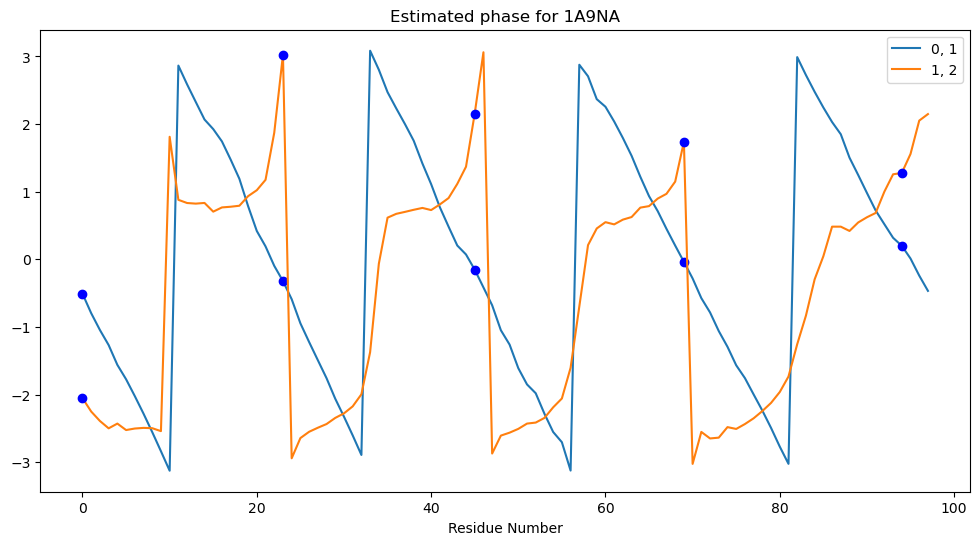

FileNotFoundError: [Errno 2] No such file or directory: 'plots/validation_autonomous/1A9NA.png'

<Figure size 640x480 with 0 Axes>

In [27]:
names = ["1A9NA", "1H6UA", "1IO0A", "1JL5A", "1O6VA", "1OGQA", "1OZNA", "1P9AG", "1PGVA", "1W8AA", "1WWLA", "1XEUA", "1XKUA", "1ZIWA", "2ASTB", "2BNHA", "2CA6A", "2ELLA", "2FT3A", "2ID5A", "2IFGA", "2JQDA", "2O6QA", "2O6RA", "2O6SA", "2P1MB", "2Q4GW", "2R9UA", "2RA8A", "2V70A", "2V9TB", "2WFHA", "2XOTA", "2XWTC", "2Z62A", "2Z63A", "2Z66A", "2Z7XA", "2Z7XB", "2Z80A", "2Z81A", "3A79B", "3B2DA", "3BZ5A", "3CIGA", "3E4GA", "3E6JA", "3G06A", "3G39A", "3GOZA", "3J0AA", "3JB9J", "3M19A", "3O53A", "3O6NA", "3OGKB", "3RFJA", "3RFSA", "3RG1A", "3RGZA", "3RW6A", "3SB4A", "3T6QA", "3TSRE", "3TWID", "3UN9A", "3V44A", "3VQ2A", "3WN4A", "3WO9A", "3WPEA", "3ZYIA", "3ZYJA", "3ZYOA", "4ARNA", "4AY9X", "4B8CD", "4BV4R", "4CILA", "4CNMA", "4CP6A", "4ECNA", "4ECOA", "4EZGA", "4FCGA", "4FD0A", "4FDWA", "4FS7A", "4G8AA", "4GLPA", "4GT6A", "4H09A", "4I6JB", "4IM6A", "4K5UA", "4KXFB", "4L3FA", "4LXRA", "4MN8A", "4MN8B", "4NKGA", "4OJUA", "4OW2A", "4P8SA", "4PBVA", "4PEQB", "4PERA", "4PKIG", "4PO4A", "4PQ8A", "4PSJA", "4Q3IA", "4Q62A", "4QDHA", "4QXEA", "4R58A", "4R6FA", "4R6GA", "4RCAB", "4RWTC", "4TZHA", "4U06A", "4U08A", "4U09A", "4UFRA", "4V2EA", "4XA9A", "4XGOA", "4XSQA", "4Y61B", "4Z5WA", "4Z63A", "4Z79A", "4Z8GA", "5B0NA", "5D3IA", "5GR8A", "5HL3A", "5HZLB", "5IRNA", "5JFKA", "5JH5A", "5KZSA", "5LFNA", "5MX0A", "5WLSA", "5XJOA", "5XKNA", "5XWUB", "5Y30A", "5Y9WA", "5YQ5A", "5YUDA", "5YXMA", "5Z8XA", "5ZB2A", "6BRPB", "6BXAC", "6BXEA", "6DBGA", "6EJXA", "6F4JA", "6FG7A", "6FG8A", "6FG8B", "6FNWA", "6G3WA", "6GFFI", "6GYUA", "6IF5A", "6J5TC", "6J6GB", "6K2DB", "6MLXA", "6NPYA", "6O60C", "6OBPC", "6R1HA"]

for code in names:
    
    try:
        motif_indices = motif_indices_d[code]
    except:
        continue
        
    if not motif_indices:
        continue
        
    motifLocs = LRR_d[code]
    period = avgper_d[code]
    # print(period)
    # print(motifLocs)
    # print(motif_indices)
    # Image(filename='plots/validation_eigenmatrix/%s.png'%code)
    
    plt.figure(figsize = (12,6))
    for eig1, eig2 in [(0,1), (1,2)]:
        if code in LRR_bnd_l.keys():
            a,b = LRR_bnd_l[code]
        else:
            a, b = motifLocs[0], motifLocs[-1]
        # print(a,b)
        v = np.load('npy/validation_eigenmatrix/%s.npy'%code)

        # plt.figure(figsize=(12, 4))
        s = v[:,eig1]
        c = v[:, eig2]
        # plt.plot(s)
        # plt.plot(c)
        # plt.show()
        # from daps import *
        # Detrend with daps
        sf = detrend_timeseries(s, period)
        cf = detrend_timeseries(c, period)

        # plt.figure(figsize=(12, 6))
        # plt.subplot(121)
        # plt.plot(sf)
        # plt.plot(cf)
        # plt.title("Detrended")
        # plt.subplot(122)
        # plt.title("Detrended Joint Plot")
        # plt.plot(sf, cf)
        # plt.show()

        # Extract the final phase and plot

        theta = np.arctan2(cf, sf)
        # plt.figure(figsize=(12, 4))
        plt.plot(theta, label=f'{eig1}, {eig2}')

        phases = []
        ommitted =[]
        plotted_motifs = []
        for res in motif_indices:
            if res-a<len(theta):
                plt.plot(res-a, theta[res-a], 'bo')
                phases.append(theta[res-a])
                plotted_motifs.append(res)
            else:
                ommitted.append(res)
                phases.append(-4)

        phases = np.array(phases)


        plt.title(f"Estimated phase for {code}")
        plt.legend()
        plt.xlabel("Residue Number")

#         np.save(make_path('npy','validation_phase', '%s.npy'%code), phases)
#         np.save(make_path('npy','validation_theta', '%s.npy'%code), theta)
#         np.save(make_path('npy','validation_plotted_motifs', '%s.npy'%code), np.array(plotted_motifs))
        # print(plotted_motifs, ommitted)

    plt.show()
    plt.savefig(make_path('plots','validation_autonomous/%s.png'%code))

    plt.close